# Importing packages and drivers

In [1]:
%matplotlib notebook

import os
import sys 
import time
import datetime

from collections import OrderedDict
from importlib import reload

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

from IPython.display import clear_output
from IPython.display import Image

import qcodes as qc
from qcodes.dataset.database import initialise_database, get_DB_location
from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.data_export import get_data_by_id

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430, AMI430_3D
from qcodes.instrument_drivers.Lakeshore.lakeshore_base import *
from qcodes.instrument_drivers.Lakeshore import Model_372
from qcodes.instrument.parameter import Parameter

from plottr import qcodes_dataset; reload(qcodes_dataset)
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.qctools import instruments as instools
from pytopo.qctools.instruments import add2station

#import broadbean

from pytopo.sweep import sweep, measure, nest, chain, szip, getter, setter, time_trace, do_experiment

from pytopo.sweep.decorators import hardsweep

from pytopo.qctools.dataset2 import select_experiment
from pytopo.qctools.measurement import MeasurementExt

import pytopo

from pytopo.awg_sequencing import broadbean as bb; reload(bb)
from pytopo.awg_sequencing.broadbean import BroadBeanSequence, BluePrints; reload(pytopo.awg_sequencing.broadbean)
from pytopo.rf.alazar import acquisition_tools; reload(acquisition_tools)
from pytopo.rf.alazar.acquisition_tools import AlazarMeasurement

from pytopo.rf.alazar import acquisition_controllers; reload(acquisition_controllers)
from pytopo.rf.alazar.awg_sequences import TriggerSequence

from broadbean.plotting import plotter

ramp_bb = bb.ramp

In [2]:
acquisition2result = acquisition_tools.AlazarMeasurement.acquisition2result
get_result = acquisition_tools.AlazarMeasurement.get_result

In [2]:
station = Station()

In [3]:
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_%Y-%m_6.db')
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

def get_timestamp(run_id):
    ds = load_by_id(run_id)
    return ds.run_timestamp_raw

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "D:/Data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [19]:
220*13.4e-3

2.948

## Pad conversion

In [4]:
sys.path.append(r"D:\OneDrive\BF3\Code\BF3")
from QT3_PCB.pad_conversion import Gen5_to_BoB

In [ ]:
Gen5_to_BoB(45,11,17,15,32)

# Initialize instruments and useful functions

In [4]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]

def ramp(param, target, step_size, delay): 
    current_value = param()
    step_size *= np.sign(target - current_value)
    if abs(step_size) < 1E-10: 
        return 
    
    steps = np.arange(current_value, target, step_size)
    for step in steps: 
        param(step)
        time.sleep(delay)
    
    param(target)

def set_mdac_in_safemode(nchan=64):
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    
    print('setting mdac in safe mode')
    
    for ch in mdac.channels[:nchan]:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

    for ch in mdac.channels[:nchan]:
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        #ch.divider('off')
    print('Done')

def chs_safe(*channels):
    sr1.amplitude(0)
    sr1.sine_outdc(0)   
    print('setting mdac in safe mode')
    for ch in channels:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
    print('Done')

def initialize(s,g):
    ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    ramp(g.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    s.smc('close')
    s.dac_output('close')
    #d.gnd('close')
    g.dac_output('close')
    g.smc('close')

bias_ramp_stepsize = 1e-3  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]
def lockin_bias(voltage): 
    voltage *= 100
    ramp(sr1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

bias = Parameter('lockin_bias', label='Bias', unit='V',
                   set_cmd=lockin_bias, get_cmd=None)

def set_mdac_TG1(voltage):
    ramp(TG1_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

mdac_TG1_param = Parameter('TG1_voltage', label='TG1', unit='V',
                          set_cmd=set_mdac_TG1, get_cmd=None)

def set_mdac_TG2(voltage):
    ramp(TG2_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

mdac_TG2_param = Parameter('TG2_voltage', label='TG2', unit='V',
                          set_cmd=set_mdac_TG2, get_cmd=None)

def set_mdac_PG(voltage):
    ramp(PG_ch.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

mdac_PG_param = Parameter('PG_voltage', label='PG', unit='V',
                          set_cmd=set_mdac_PG, get_cmd=None)


def awg_trigger_func():
    #if do_start:
    time.sleep(2)
    awg.force_triggerA()
    #print('triggered')
    
    
def trigger_awg_when_ready(awg):
    """
    AWG-model independent trigger. waits until the AWG is ready to receive a trigger.
    """
    while awg.run_state() != 'Waiting for trigger':
        time.sleep(0.01)
    awg.force_triggerA()

## Lockins

In [47]:
sr1 = SR860("sr1", "GPIB0::4::INSTR")
sr1.amplitude.vals._min_value = 0
station = add2station(station, sr1)

sr2 = SR860("sr2", "TCPIP0::192.168.0.170")
sr2.amplitude.vals._min_value = 0
station = add2station(station, sr2)

Connected to: Stanford_Research_Systems SR860 (serial:003223, firmware:v1.51) in 0.20s
Connected to: Stanford_Research_Systems SR860 (serial:003214, firmware:V1.47) in 0.17s


In [7]:
print('lockin1 excitation amplitude =', sr1.amplitude(), 'V')
print('lockin1 DC bias =', sr1.sine_outdc(), 'V')
print('lockin1 frequency =', sr1.frequency(), 'Hz')
print('lockin1 phase =', sr1.phase(), 'deg')
print('lockin1 X =', sr1.X(), 'V')
print('lockin1 Y =', sr1.Y(), 'V')
print('lockin1 R =', sr1.R(), 'V')
print('lockin1 P =', sr1.P(), 'deg')

lockin1 excitation amplitude = 0.0 V
lockin1 DC bias = 0.0 V
lockin1 frequency = 19.3 Hz
lockin1 phase = -180.0 deg
lockin1 X = -8.9460894515e-07 V
lockin1 Y = 1.8921140281e-06 V
lockin1 R = 2.1362584448e-06 V
lockin1 P = 125.11203766 deg


In [8]:
print('lockin2 excitation amplitude =', sr2.amplitude(), 'V')
print('lockin2 DC bias =', sr2.sine_outdc(), 'V')
print('lockin2 frequency =', sr2.frequency(), 'Hz')
print('lockin2 phase =', sr2.phase(), 'deg')
print('lockin2 X =', sr2.X(), 'V')
print('lockin2 Y =', sr2.Y(), 'V')
print('lockin2 R =', sr2.R(), 'V')
print('lockin2 P =', sr2.P(), 'deg')

lockin2 excitation amplitude = 0.0 V
lockin2 DC bias = 0.0 V
lockin2 frequency = 19.17 Hz
lockin2 phase = 0.0 deg
lockin2 X = 6.7781662949e-08 V
lockin2 Y = 2.8898008964e-07 V
lockin2 R = 3.6302137119e-07 V
lockin2 P = 80.931617737 deg


In [ ]:
sr1 = qc.find_or_create_instrument(SR860, "sr1", recreate=True, address="GPIB0::4::INSTR")
sr2 = qc.find_or_create_instrument(SR860, "sr2", recreate=True, address="TCPIP0::192.168.0.170")

## MDAC

In [21]:
sys.path.append(r"D:\OneDrive\BF3\Code\StationQ\MDAC\Driver")
from MDAC import MDAC
mdac = MDAC('MDAC1', 'ASRL5::INSTR', debug=False, logging=False)
station = add2station(station, mdac)
set_mdac_in_safemode()

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\ctwrapper\functions.py:1649: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x32353532353551040028003E, firmware:1.4) in 2.72s


NameError: name 'sr1' is not defined

## RF

In [5]:
from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208
awg = instools.create_inst(AWG5208, "awg", address='TCPIP0::169.254.2.3')
station = add2station(station,awg)
awg.timeout(100)

# if isinstance(station.awg, AWG5014):
#     AWGTYPE = '5014'
# elif isinstance(station.awg, AWG5208):
#     AWGTYPE = '5208'
# else:
#     raise Exception('No usable AWG.')
    
# print(AWGTYPE)

# Variable attenuator
from qcodes.instrument_drivers.Minicircuits.RUDAT_13G_90 import RUDAT_13G_90_USB
ro_att = instools.create_inst(RUDAT_13G_90_USB, 'ro_att', force_new_instance=True)
station = add2station(station, ro_att)

# Alazar
from qcodes.instrument_drivers.AlazarTech import utils; reload(utils)
from qcodes.instrument_drivers.AlazarTech import ATS9360; reload(ATS9360)
from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar', force_new_instance=True)
station = add2station(station, alazar)

# Alazar aquisition controllers
# from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
# from pytopo.rf.alazar_acquisition import RawAcqCtl, AvgDemodCtl, AvgIQCtl

# raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
# station = add2station(station, raw_acq)

# avgdemod_acq = instools.create_inst(AvgDemodCtl, 'avgdemod_acq', 'alazar', force_new_instance=True)
# station = add2station(station, avgdemod_acq)

# avgiq_acq = instools.create_inst(AvgIQCtl, 'avgiq_acq', 'alazar', force_new_instance=True)
# station = add2station(station, avgiq_acq)

# RF sources
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.2.20", force_new_instance=True)
station = add2station(station, LO)

RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.251.130", force_new_instance=True)
station = add2station(station, RF)

#from qcodes.instrument_drivers.agilent.E8267C import E8267
#S1 = instools.create_inst(E8267, 'S1', address='GPIB0::19::INSTR', force_new_instance=True)
#inst_list.append(S1)

from pytopo.rf.sources import HeterodyneSource
hetsrc = instools.create_inst(HeterodyneSource, 'hetsrc', RF=RF, LO=LO, force_new_instance=True)
station = add2station(station, hetsrc)

awg.wfmxFileFolder = "\\Users\\MSFTE\\Documents"
awg.seqxFileFolder = "\\Users\\MSFTE\\Documents"

from qcodes.instrument_drivers.rigol.DG1062 import DG1062
fg = instools.create_inst(DG1062, 'fg', address = 'TCPIP0::169.254.217.87::INSTR', force_new_instance=True)

Connected to: TEKTRONIX AWG5208 (serial:B020206, firmware:FV:6.1.0054.0) in 0.84s
Connected to: Mini-Circuits MN=RUDAT-13G-90 (serial:SN=11704210056, firmware:C9-2) in 0.61s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110530, firmware:3.1.19.15-3.50.124.67) in 0.05s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110529, firmware:3.1.19.15-3.50.124.67) in 0.04s
Connected to: Rigol Technologies DG1062Z (serial:DG1ZA193303264, firmware:00.01.12) in 0.06s


### Alazar controllers

In [6]:
post_iq_acq = instools.create_inst(acquisition_controllers.PostIQCtl, 
                                   'post_iq_acq', 'alazar',
                                   allocate_samples=1e9, 
                                   force_new_instance=True)
station = add2station(station, post_iq_acq)

raw_acq = instools.create_inst(acquisition_controllers.RawAcqCtl, 
                                   'raw_acq', 'alazar',
                                   allocate_samples=1e9, 
                                   force_new_instance=True)
station = add2station(station, raw_acq)

Allocating 1000000000 elements (4000.0 MB, dtype: <class 'numpy.int32'>)
Allocating 1000000000 elements (2000.0 MB, dtype: <class 'numpy.uint16'>)


### Alazar settings

In [7]:
with alazar.syncing():
    alazar.clock_source('INTERNAL_CLOCK') #INTERNAL_CLOCK EXTERNAL_CLOCK_10MHz_REF
    alazar.sample_rate(int(0.2e9))
    alazar.clock_edge('CLOCK_EDGE_RISING')
    #alazar.external_sample_rate(int(1e9))
    alazar.decimation(1)
    alazar.coupling1('DC')
    alazar.coupling2('DC')
    alazar.channel_range1(0.4)
    alazar.channel_range2(0.4)
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_source1('EXTERNAL')
    alazar.trigger_level1(128 + 20)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_2V5') #ETR_TTL
    alazar.trigger_delay(0)
    alazar.timeout_ticks(int(1e6))
    alazar.buffer_timeout(int(1e3))

# DC settings

In [48]:
sr1.R()

4.6759828365e-06

In [49]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


In [50]:
source = mdac.ch58
TG1_ch = mdac.ch10;
PG_ch = mdac.ch18;
TG2_ch = mdac.ch26;
#PG2_ch = mdac.ch33;

initialize(source, TG1_ch)
initialize(source, PG_ch)
initialize(source, TG2_ch)

In [55]:
set_mdac_PG(-0.2)
set_mdac_TG1(0)

# Soft sweep

In [170]:
TriggerSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', None],
}

post_iq_acq.pre_acquire_func = awg_trigger_func
post_iq_acq.average_buffers(False)

samples = 1024 #dummy number, if acquisition_time is specified that's what determines the number of samples
records = 1
buffers = 1
acq_time = 50e-6

post_iq_acq.demod_frq(20e6)
post_iq_acq.setup_acquisition(samples, records, buffers, acq_time = acq_time)


ro_trigger = TriggerSequence(awg)

d:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Setup capture: 0.319488 MB total
 * Buffers: 1 (0.319488 MB/buffer) | (Allocated buffers: 1 = 0.319488 MB)
 * Records: 1 (0.319488 MB/record)
 * Samples: 39936 (= 49.92 us)
 * Channels: 2


ro_trigger not defined. omitting.


<IPython.core.display.Javascript object>


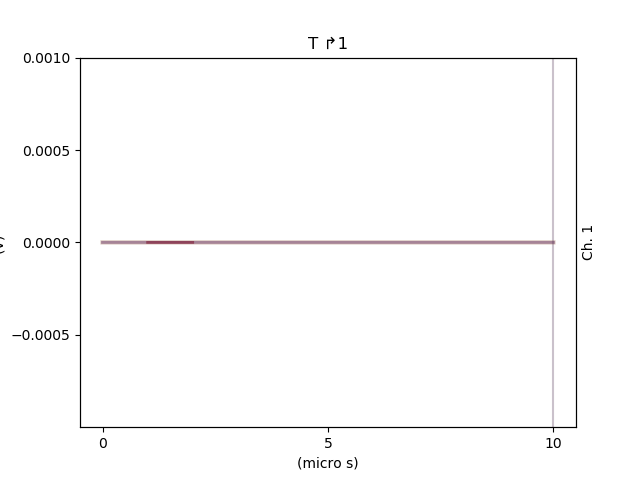

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


In [171]:
ro_trigger.setup_awg(program_awg=True, plot=True)

In [172]:
data = post_iq_acq.acquisition()

In [173]:
data

array([[[[ 0.02887701-0.00172252j, -0.00619188-0.00293502j]]]])

# Check Ramp

In [752]:
class CheckRamp(BroadBeanSequence):
    
    name = 'voltage_ramp'
    trigger_delay = 10e-6
    alazar_trigger_len = 1e-6
    voltages = []
        
        
    def sequence(self, initial_delay, start_voltage, stop_voltage, voltage_points, ramp_down_time, step_len, SR):
        self.voltages = np.linspace(start_voltage, stop_voltage, voltage_points)
        
        
        elements = []
        bps = BluePrints(self.chan_map, sample_rate=SR)
        
        cut_t = 0
        bps['ro_trigger'] = []
        bps['awg_voltage'].insertSegment(0, ramp_bb, (start_voltage, start_voltage), 
                                         dur=initial_delay, name='voltage')        
        for i, v in enumerate(self.voltages):
            bps['awg_voltage'].insertSegment(i+1, ramp_bb, (v, v), 
                                             dur=step_len, name='voltage')
           
        bps['awg_voltage'].insertSegment(-1, ramp_bb, (v, start_voltage), 
                                         dur=ramp_down_time, name='voltage')        

        elements.append(bb.blueprints2element(bps))
        
        
       
        return bb.elements2sequence(elements, self.name)
        

<IPython.core.display.Javascript object>


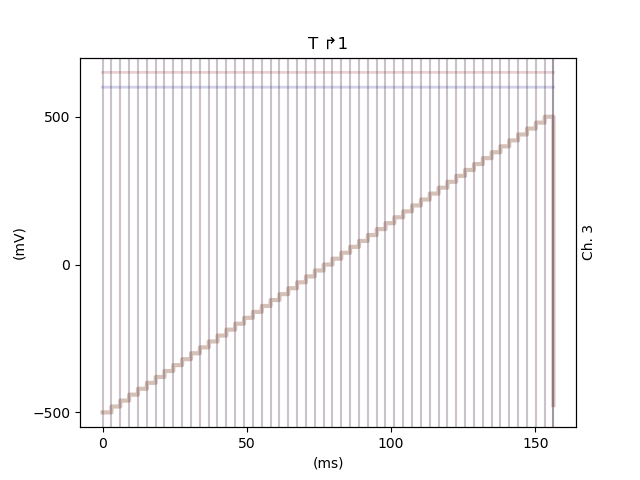

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


In [754]:
delay_1 = 8e-6
step_len_1 = 60e-6
pts_1 = 51
startV_1 = 0
stopV_1 = -0.5

delay_2 = 4e-6
step_len_2 = step_len_1*pts_1 + (delay_1 - delay_2)
pts_2 = 51
startV_2 = -0.1
stopV_2 = 0.1

t_rd = delay_1 - delay_2

seq_SR = 1e7 #1e9


check_ramp = CheckRamp(awg)

check_ramp.chan_map = {
    3 : ['awg_voltage', 'ro_trigger'],
}
check_ramp.chan_settings[3]['Vpp'] = 1.0
check_ramp.chan_settings[3]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
check_ramp.chan_settings[3]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]

check_ramp.wait = 'first' #trigger wait to True before first element
check_ramp.setup_awg(program_awg=True, start_awg=True, stop_awg=False,
                  initial_delay=delay_2, step_len=step_len_2, voltage_points=pts_2, start_voltage=-0.5, stop_voltage=0.5,
                  ramp_down_time=t_rd, SR=seq_SR, plot=True)

awg.sample_rate(seq_SR)
awg.ch3.setWaveform(awg.waveformList[0])

In [755]:
awg.force_triggerA()

# 1D hard sweep

In [119]:
class AWGRamp1D(BroadBeanSequence):
    
    name = 'voltage_ramp'
    trigger_delay = 10e-6
    alazar_trigger_len = 1e-6
    voltages = []
        
        
    def sequence(self, initial_delay, start_voltage, stop_voltage, voltage_points, ramp_down_time, step_len, SR):
        self.voltages = np.linspace(start_voltage, stop_voltage, voltage_points)
        
        #elem = bb.Element()
        elements = []
        bps = BluePrints(self.chan_map, sample_rate=SR)
        
        cut_t = 0
        bps['ro_trigger'] = []
        bps['awg_voltage'].insertSegment(0, ramp_bb, (start_voltage, start_voltage), 
                                         dur=initial_delay, name='voltage')        
        for i, v in enumerate(self.voltages):
            bps['awg_voltage'].insertSegment(i+1, ramp_bb, (v, v), 
                                             dur=step_len, name='voltage')
            bps['ro_trigger'].append((initial_delay + step_len * i + self.trigger_delay, 
                                      self.alazar_trigger_len))
            
        bps['awg_voltage'].insertSegment(-1, ramp_bb, (v, start_voltage), 
                                         dur=ramp_down_time, name='voltage')        

        elements.append(bb.blueprints2element(bps))
        
        
        #seq = bb.Sequence()
        #seq.name = 'v_ramp'
        #seq.addElement(1, elem)
        
        return bb.elements2sequence(elements, self.name)
        

<IPython.core.display.Javascript object>


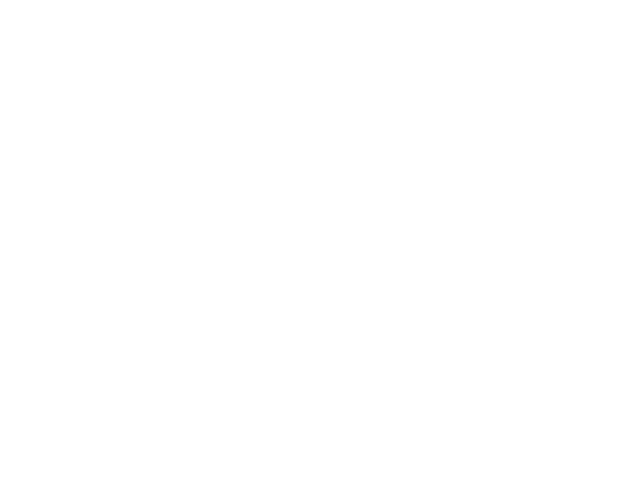

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


KeyboardInterrupt: 

In [387]:
test_seq = AWGRamp1D(awg)

test_seq.chan_map = {
    1 : ['awg_voltage', 'ro_trigger'],
}
test_seq.chan_settings[1]['Vpp'] = 1.0
test_seq.chan_settings[1]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[1]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]

test_seq.wait = 'first' #trigger wait to True before first element
test_seq.setup_awg(program_awg=True, start_awg=True, stop_awg=False,
                  initial_delay=10e-6, step_len=60e-6, voltage_points=11, start_voltage=0, stop_voltage=-0.5,
                  ramp_down_time=10e-6, SR=1e9, plot=True)

gate_voltages = test_seq.voltages

#NB: Be careful that reducing sampling rate for awg makes the sequence incorrect (much shorter), even if the plot
#    below is fine...


In [180]:
hetsrc.frequency(410e6)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)
ro_att.attenuation(10)

post_iq_acq.pre_acquire_func = awg_trigger_func #trigger_awg_when_ready(awg) #awg_trigger_func
post_iq_acq.average_buffers(True)

samples = None #dummy number, if acquisition_time is specified that's what determines the number of samples
records = 301
buffers = 1
acq_time = 10e-6
post_iq_acq.demod_frq(20e6)
post_iq_acq.setup_acquisition(samples, records, buffers, acq_time = acq_time)



d:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Setup capture: 4.62336 MB total
 * Buffers: 1 (4.62336 MB/buffer) | (Allocated buffers: 1 = 4.62336 MB)
 * Records: 301 (0.015359999999999999 MB/record)
 * Samples: 1920 (= 9.6 us)
 * Channels: 2


In [181]:
@hardsweep(ind=[('gate_voltages', 'V', 'array')], dep=[('ch1_mag', 'V', 'array'),('ch2_mag', 'V', 'array'),
                                                      ('ch1_phase','deg','array'),('ch2_phase','deg','array')])
def alazar_meas(gate_voltages):
    
    data = post_iq_acq.acquisition()
    return gate_voltages, [np.abs(data[0,0,:,0]), np.abs(data[0,0,:,1]), np.angle(data[0,0,:,0]), np.angle(data[0,0,:,1])]

so = sweep(bias, np.linspace(-15e-3, 15e-3, 101))(alazar_meas(gate_voltages))

result = do_experiment('Test/None', so, live_plot=True)

Starting experimental run with id: 81


In [289]:
hetsrc.RF.off()
hetsrc.LO.off()

In [124]:
alazar.samples_per_record()/alazar.sample_rate()*1e6

9.6

In [125]:
alazar.samples_per_record()

1920

# 2D hard sweep

In [8]:
class AWGRamp2D(BroadBeanSequence):
    
    name = 'voltage_ramp'
    trigger_delay = 6e-6
    alazar_trigger_len = 6e-6
    voltages_1 = []
    voltages_2 = []
        
    def sequence(self, initial_delay, start_voltage_1, stop_voltage_1, voltage_points_1, step_len_1, ramp_down_time_1,
                 start_voltage_2, stop_voltage_2, voltage_points_2, ramp_down_time_2, SR):
        
        self.voltages_1 = np.linspace(start_voltage_1, stop_voltage_1, voltage_points_1)
        self.voltages_2 = np.linspace(start_voltage_2, stop_voltage_2, voltage_points_2)
        
        elements = []

        for i2,v2 in enumerate(self.voltages_2):
            bps = BluePrints(self.chan_map, sample_rate=SR)
            bps['ro_trigger'] = []
            
            if i2 == 0:
                bps['fast'].insertSegment(0, ramp_bb, (start_voltage_1, start_voltage_1),
                                          dur=initial_delay, name='voltage')  
                bps['slow'].insertSegment(0, ramp_bb, (start_voltage_2, start_voltage_2),
                                          dur=initial_delay, name='voltage')   
            
            
            for i, v in enumerate(self.voltages_1):
                bps['fast'].insertSegment(i+1+(i2+1)*voltage_points_1, ramp_bb, (v, v), 
                                                 dur=step_len_1, name='voltage')
                bps['ro_trigger'].append((initial_delay + step_len_1*i + self.trigger_delay, 
                                          self.alazar_trigger_len))
                
                
                bps['slow'].insertSegment(i+1+(i2+1)*voltage_points_1, ramp_bb, (v2, v2), 
                                                 dur=step_len_1, name='voltage')
            if i2 == len(self.voltages_2)-1:
                bps['fast'].insertSegment(i+1+(i2+1)*voltage_points_1, ramp_bb, (stop_voltage_1, 0),
                                          dur=ramp_down_time_2, name='voltage')        
                bps['slow'].insertSegment(i+1+(i2+1)*voltage_points_1, ramp_bb, (stop_voltage_2, 0),
                                          dur=ramp_down_time_2, name='voltage') 
            else:                   
                bps['fast'].insertSegment(i+1+(i2+1)*voltage_points_1, ramp_bb, (stop_voltage_1, start_voltage_1), 
                                             dur=ramp_down_time_1, name='voltage')        
                bps['slow'].insertSegment(i+1+(i2+1)*voltage_points_1, ramp_bb, (v2,v2), 
                                                 dur=ramp_down_time_1, name='voltage') 

        
            
            elements.append(bb.blueprints2element(bps))
        
        
        return bb.elements2sequence(elements, self.name)
        

In [888]:
pts_2 = 101
longest_ramp_time = delay_2 + pts_2*step_len_2 + t_rd
sample_num = longest_ramp_time*seq_SR
print('Long ramp length = {} ms'.format(longest_ramp_time*1e3))
print('Samples number = {} (mega-samples)'.format(sample_num/1e6))


Long ramp length = 309.47200000000004 ms
Samples number = 3.0947200000000006 (mega-samples)


In [30]:
%%time

initial_delay = 10e-6
t_rd_fast = 4e-6
t_rd_final = 10e-6

#fast ramp values
step_len = 60e-6
pts_1 = 150
startV_1 = -0.1
stopV_1 = 0.1

#slow ramp values
pts_2 = 150
startV_2 = 0
stopV_2 = -0.4

seq_SR = 1e7 #1e9

test_seq = AWGRamp2D(awg, SR=seq_SR)

test_seq.chan_map = {
    1 : ['fast', 'ro_trigger'],
    2 : ['slow', None],
}
test_seq.chan_settings[1]['Vpp'] = 1.0
test_seq.chan_settings[1]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[1]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]
test_seq.chan_settings[2]['Vpp'] = 1.0
test_seq.chan_settings[2]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[2]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]


test_seq.wait = 'first' #trigger wait to True before first element

test_seq.setup_awg(program_awg=True, start_awg=True, initial_delay=initial_delay, step_len_1=step_len,
                   voltage_points_1=pts_1, start_voltage_1=startV_1, stop_voltage_1=stopV_1,
                  voltage_points_2=pts_2, start_voltage_2=startV_2, stop_voltage_2=stopV_2,
                  ramp_down_time_1=t_rd_fast, ramp_down_time_2=t_rd_final, SR=seq_SR, plot=False)


# Change this if you change order of ramps...
bias_voltages = test_seq.voltages_1
gate_voltages = test_seq.voltages_2

#NB: Be careful that reducing sampling rate for awg makes the sequence incorrect (much shorter), even if the plot
#    below is fine...

# factor of 10 in bias (and 2 for bias and gate because of 50Ohm)

# Pay attention to ratio between sampling rate and length in time of steps and so on (especially for trigger because
# broadbean doesn't see it as an error...)

# Pay attention to sampling rate and output of AWG, if too low not synchronized?


Wall time: 59.4 s


In [496]:
awg.force_triggerA()

In [53]:
hetsrc.frequency(410e6)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)
ro_att.attenuation(10)

acq_controller = post_iq_acq #post_iq_acq #raw_acq #or post...

acq_controller.pre_acquire_func = awg_trigger_func #trigger_awg_when_ready(awg) #awg_trigger_func
acq_controller.average_buffers(False)

samples = None #dummy number, if acquisition_time is specified that's what determines the number of samples
records = len(gate_voltages)
buffers = len(bias_voltages)
acq_time = 5e-6
acq_controller.demod_frq(20e6)
acq_controller.setup_acquisition(samples, records, buffers, acq_time = acq_time)


Setup capture: 161.28 MB total
 * Buffers: 150 (1.0752 MB/buffer) | (Allocated buffers: 150 = 161.28 MB)
 * Records: 150 (0.007168 MB/record)
 * Samples: 896 (= 4.48 us)
 * Channels: 2


In [56]:
@hardsweep(ind=[('gate_voltages', 'V', 'array'),('bias_voltages', 'V', 'array')], 
           dep=[('ch1_mag', 'V', 'array'),('ch2_mag', 'V', 'array'),
                ('ch1_phase','deg','array'),('ch2_phase','deg','array')])
def alazar_meas(gate_voltages, bias_voltages):
    
    data = acq_controller.acquisition()
    
    slow_axis, fast_axis = np.meshgrid(gate_voltages, bias_voltages, indexing='ij')
    #good if buffers are used "as records" and or for averaging, otherwise need to separate buffers first 
    ch_1 = np.squeeze(data)[...,0].reshape(-1)
    ch_2 = np.squeeze(data)[...,1].reshape(-1)
    
    return np.vstack((slow_axis.reshape(-1), fast_axis.reshape(-1))), \
           [np.abs(ch_1), np.abs(ch_2), np.angle(ch_1), np.angle(ch_2)]

so = alazar_meas(gate_voltages, bias_voltages)

result = do_experiment('Test/None', so, live_plot=True)

Starting experimental run with id: 193


In [57]:
hetsrc.RF.off()
hetsrc.LO.off()

In [18]:
data = acq_controller.acquisition()

<IPython.core.display.Javascript object>


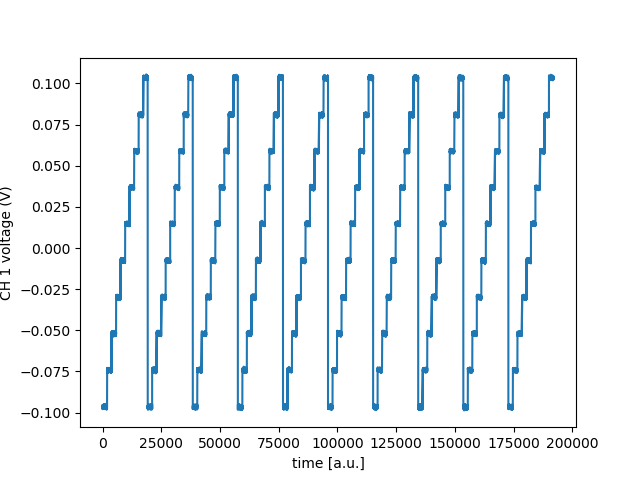

In [19]:
ch_1 = np.squeeze(data)[...,0].reshape(-1)
plt.figure()
plt.xlabel('time [a.u.]')
plt.ylabel('CH 1 voltage (V)')
plt.plot(ch_1)

<IPython.core.display.Javascript object>


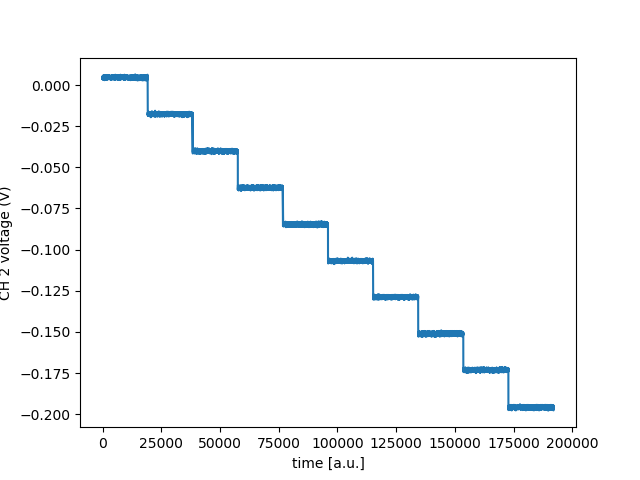

In [20]:
ch_2 = np.squeeze(data)[...,1].reshape(-1)

plt.figure()
plt.xlabel('time [a.u.]')
plt.ylabel('CH 2 voltage (V)')
plt.plot(ch_2)

## Try with Alazar measurement class

In [ ]:
exp = select_experiment('2DHardSweep_test', 'Q0169_QPC_2nd_cooldown') 


meas = AlazaMeasurement(station, exp=exp, 
                      hard_axes=[],
                      soft_params=[],
                      mag=True, phase=True
                     )


meas.write_period = 2                 #how often to write to the DB [s]
with meas.run() as datasaver:
    
    plot_subscriber = QcodesDatasetSubscriber(datasaver.dataset)
    datasaver.dataset.subscribe(plot_subscriber, state=[])
    

    data = post_iq_acq.acquisition()
    datasaver.add_result(*meas.get_result()) # this adds all data to the datasaver.


In [285]:
hetsrc.frequency(410e6)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)
ro_att.attenuation(10)

post_iq_acq.pre_acquire_func = awg_trigger_func #trigger_awg_when_ready(awg) #awg_trigger_func
post_iq_acq.average_buffers(False)

samples = None #dummy number, if acquisition_time is specified that's what determines the number of samples
records = 11*11
buffers = 1
acq_time = 10e-6
post_iq_acq.demod_frq(20e6)
post_iq_acq.setup_acquisition(samples, records, buffers, acq_time = acq_time)


d:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Setup capture: 1.8585599999999998 MB total
 * Buffers: 1 (1.8585599999999998 MB/buffer) | (Allocated buffers: 1 = 1.8585599999999998 MB)
 * Records: 121 (0.015359999999999999 MB/record)
 * Samples: 1920 (= 9.6 us)
 * Channels: 2


In [286]:
data = post_iq_acq.acquisition()

In [287]:
data.shape

(1, 1, 121, 2)

In [288]:
d = data[0,0,:,0]

In [292]:
d = d.reshape(len(gate_voltages), len(bias_voltages))

In [274]:
d = {}
for i in range(11):
    d[i] = data[0,i,:,0]

In [276]:
d = data[0, :, :, 0]

<IPython.core.display.Javascript object>


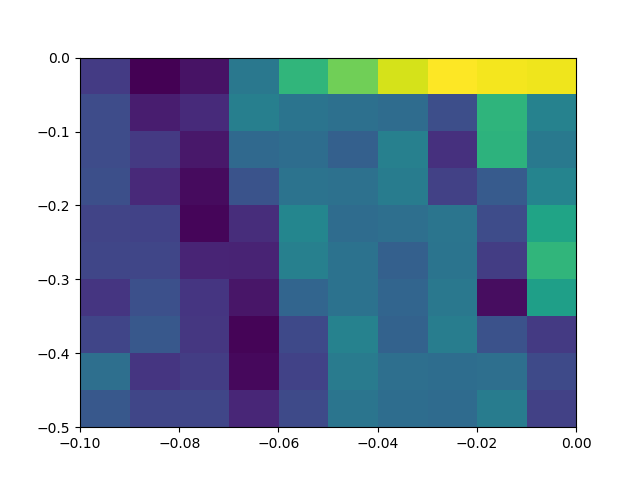

In [293]:
x_ax = gate_voltages
y_ax = bias_voltages

plt.figure()
plt.pcolor(y_ax,x_ax,np.abs(d))

<IPython.core.display.Javascript object>


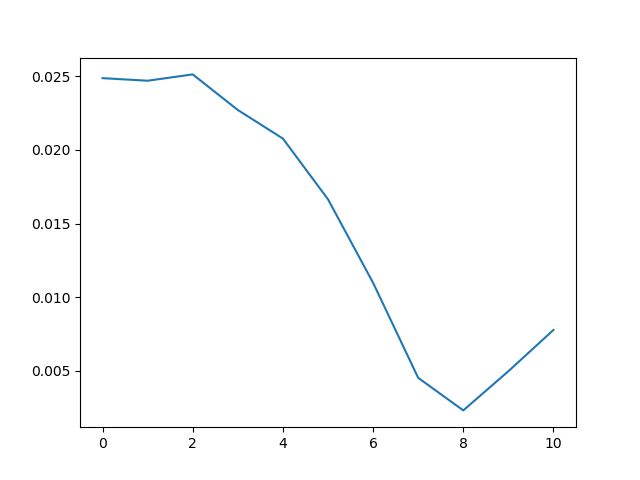

In [273]:
plt.figure()
plt.plot(np.abs(d1))

# Make sequence if broadbean doesn't work

In [1154]:
def setup_awg_changed(s, **kw):
    seq = s.sequence(**kw)
    seq.setSR(s.SR)

    for ch_no, ch_set in s.chan_settings.items():
        seq.setChannelAmplitude(ch_no, ch_set['Vpp'])
        seq.setChannelOffset(ch_no, ch_set['offset'])

    if s.wait == 'first':
        seq.setSequencingTriggerWait(1, 1)
    elif s.wait == 'off':
        seq.setSequencingTriggerWait(1, 0)
    elif s.wait == None:
        pass
    else:
        raise ValueError("Unknown sweep_wait setting '{}".format(s.wait))

    if s.repeat_mode == 'sequence':
        seq.setSequencingGoto(seq.length_sequenceelements, 1)
    elif s.repeat_mode == None:
        pass
    else:
        raise ValueError("Unknown sweep_repeat setting '{}".format(self.repeat_mode))

#     plotter(seq)

    forged_sequence = seq.forge()

    # create a sequence file
    seqx_file = s.awg.make_SEQX_from_forged_sequence(
        forged_sequence, [1 for i in s.chan_map.keys()], seq.name)
    seqx_file_name = f'{seq.name}.seqx'

    # clear lists of sequences and waveforms on the instrument in order
    # to prevent cluttering
    s.awg.clearSequenceList()
    s.awg.clearWaveformList()

    # send the sequence file to the instrument and load it
    s.awg.sendSEQXFile(seqx_file, filename=seqx_file_name)
    s.awg.loadSEQXFile(seqx_file_name)

    s.awg.sample_rate(s.SR)
    
    # load seqs to channels
    for ch_no, ch_desc in s.chan_map.items():
        chan = s.awg.channels[ch_no-1]

        track_number = 1
        chan.setSequenceTrack(seq.name, track_number)
        
#     awg.ch1.setWaveform(awg.waveformList[1])
#     awg.ch2.setWaveform(awg.waveformList[0])

In [1158]:
%%time

delay_1 = 8e-6
step_len_1 = 30e-6
pts_1 = 51
startV_1 = 0
stopV_1 = -0.5

delay_2 = 4e-6
step_len_2 = step_len_1*pts_1 + (delay_1 - delay_2)
pts_2 = 101
startV_2 = -0.1
stopV_2 = 0.1

t_rd = delay_1 - delay_2


seq_SR = 1e7

test_seq = AWGRamp2D(awg, SR=seq_SR)

test_seq.chan_map = {
    1 : ['fast', 'ro_trigger_g'],
    2 : ['slow', 'ro_trigger_b'],
}
test_seq.chan_settings[1]['Vpp'] = 1.0
test_seq.chan_settings[1]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[1]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]
test_seq.chan_settings[2]['Vpp'] = 1.0
test_seq.chan_settings[2]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]

test_seq.wait = 'first'


setup_awg_changed(test_seq, initial_delay_1=delay_1, step_len_1=step_len_1, voltage_points_1=pts_1, start_voltage_1=startV_1, stop_voltage_1=stopV_1,
                  initial_delay_2=delay_2, step_len_2=step_len_2, voltage_points_2=pts_2, start_voltage_2=startV_2, stop_voltage_2=stopV_2,
                  ramp_down_time_1=t_rd, ramp_down_time_2=t_rd, SR=seq_SR)


# gate_voltages = test_seq.voltages_1
# bias_voltages = test_seq.voltages_2

# awg.play()

Waveforms done
['wfm_1_1_1', 'wfm_1_1_2']
True debug
[['wfm_1_1_1', 'wfm_1_1_2']]
Wall time: 2min 13s


In [589]:
awg.sample_rate(seq_SR)

In [590]:
hetsrc.frequency(410e6)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)
ro_att.attenuation(10)

post_iq_acq.pre_acquire_func = awg_trigger_func #trigger_awg_when_ready(awg) #awg_trigger_func
post_iq_acq.average_buffers(False)

samples = None #dummy number, if acquisition_time is specified that's what determines the number of samples
records = len(gate_voltages)*len(bias_voltages)
buffers = 1
acq_time = 10e-6
post_iq_acq.demod_frq(20e6)
post_iq_acq.setup_acquisition(samples, records, buffers, acq_time = acq_time)


d:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Setup capture: 39.951359999999994 MB total
 * Buffers: 1 (39.951359999999994 MB/buffer) | (Allocated buffers: 1 = 39.951359999999994 MB)
 * Records: 2601 (0.015359999999999999 MB/record)
 * Samples: 1920 (= 9.6 us)
 * Channels: 2


In [591]:
@hardsweep(ind=[('gate_voltages', 'V', 'array'),('bias_voltages', 'V', 'array')], 
           dep=[('ch1_mag', 'V', 'array'),('ch2_mag', 'V', 'array'),
                ('ch1_phase','deg','array'),('ch2_phase','deg','array')])
def alazar_meas(gate_voltages, bias_voltages):
    gate_voltages_meshgrid, bias_voltages_meshgrid = np.meshgrid(gate_voltages, bias_voltages)
    gate_voltages_vector = gate_voltages_meshgrid.ravel()
    bias_voltages_vector = bias_voltages_meshgrid.ravel()
    
    data = post_iq_acq.acquisition()
    
    return [gate_voltages_vector, bias_voltages_vector], \
           [np.abs(data[0,0,:,0]), np.abs(data[0,0,:,1]), np.angle(data[0,0,:,0]), np.angle(data[0,0,:,1])]

so = alazar_meas(gate_voltages, bias_voltages)

result = do_experiment('Test/None', so, live_plot=True)

Starting experimental run with id: 93


RuntimeError: ('error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [2396, c_void_p(2174126784512), 10000]', 'getting post_iq_acq_acquisition')

<IPython.core.display.Javascript object>


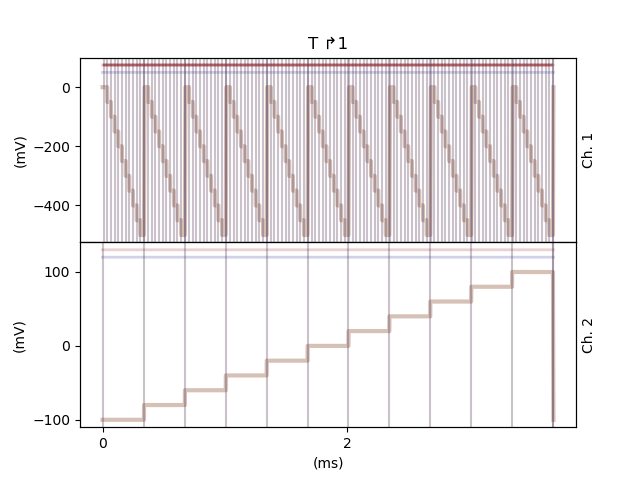

Waveforms done
['wfm_1_1_1', 'wfm_1_1_2']
True debug
[['wfm_1_1_1', 'wfm_1_1_2']]


In [587]:
delay_1 = 8e-6
step_len_1 = 30e-6
pts_1 = 11
startV_1 = 0
stopV_1 = -0.5

delay_2 = 4e-6
step_len_2 = step_len_1*pts_1 + (delay_1 - delay_2)
pts_2 = 11
startV_2 = -0.1
stopV_2 = 0.1

t_rd = delay_1 - delay_2

seq_SR = 1e9

test_seq = AWGRamp2D(awg)

test_seq.chan_map = {
    1 : ['gate_voltage', 'ro_trigger_g'],
    2 : ['bias_voltage', 'ro_trigger_b'],
}
test_seq.chan_settings[1]['Vpp'] = 1.0
test_seq.chan_settings[1]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[1]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]
test_seq.chan_settings[2]['Vpp'] = 1.0
test_seq.chan_settings[2]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]

test_seq.wait = 'first'


setup_awg_changed(test_seq, initial_delay_1=delay_1, step_len_1=step_len_1, voltage_points_1=pts_1, start_voltage_1=startV_1, stop_voltage_1=stopV_1,
                  initial_delay_2=delay_2, step_len_2=step_len_2, voltage_points_2=pts_2, start_voltage_2=startV_2, stop_voltage_2=stopV_2,
                  ramp_down_time_1=t_rd, ramp_down_time_2=t_rd, SR=seq_SR)

gate_voltages = test_seq.voltages_1
bias_voltages = test_seq.voltages_2

awg.play()


In [541]:
data.shape

(1, 1, 2601, 2)

In [527]:
data = post_iq_acq.acquisition()

In [542]:
d = data[0,0,:,0]

In [544]:
d = d.reshape(51,-1)

In [545]:
d.shape

(51, 51)

<IPython.core.display.Javascript object>


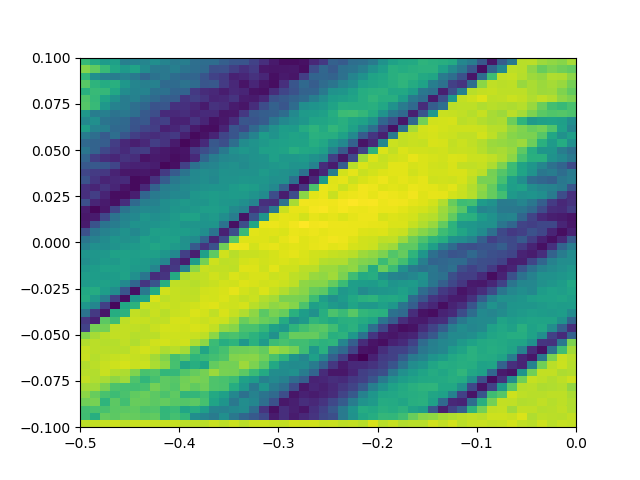

In [546]:
plt.figure()
plt.pcolor(gate_voltages,bias_voltages, np.abs(d))

<IPython.core.display.Javascript object>


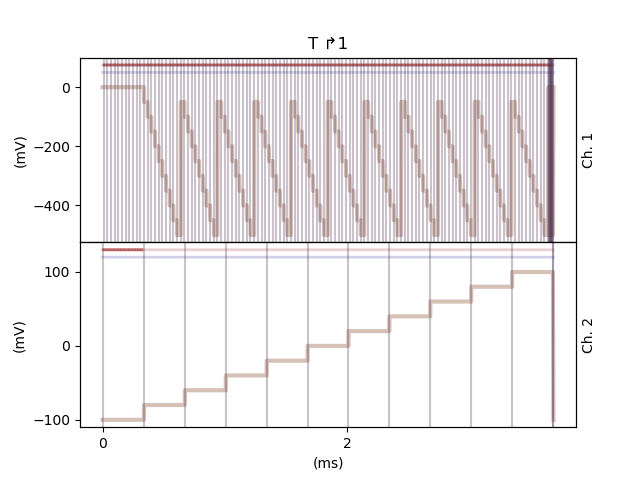

Waveforms done
['wfm_1_1_1', 'wfm_1_1_2']
True debug
[['wfm_1_1_1', 'wfm_1_1_2']]


In [550]:
seq_SR = 1e9

test_seq = AWGRamp2D(awg)

test_seq.chan_map = {
    1 : ['gate_voltage', 'ro_trigger_g'],
    2 : ['bias_voltage', 'ro_trigger_b'],
}
test_seq.chan_settings[1]['Vpp'] = 1.0
test_seq.chan_settings[1]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[1]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]
test_seq.chan_settings[2]['Vpp'] = 1.0
test_seq.chan_settings[2]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[2]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]



setup_awg_changed(test_seq, initial_delay_1=8e-6, step_len_1=30e-6, voltage_points_1=11, start_voltage_1=0, stop_voltage_1=-0.5,
                  initial_delay_2=4e-6, step_len_2=334e-6, voltage_points_2=11, start_voltage_2=-0.1, stop_voltage_2=0.1,
                  ramp_down_time_1=4e-6, ramp_down_time_2=4e-6, SR=seq_SR)


In [481]:
(10+60*11+10)*11

7480

In [492]:
29+675*11+26

7480

In [ ]:
seq_SR = 2e5
awg.sample_rate(seq_SR)

test_seq = AWGRamp2D(awg)

test_seq.chan_map = {
    1 : ['gate_voltage', 'ro_trigger_g'],
    2 : ['bias_voltage', 'ro_trigger_b'],
}
test_seq.chan_settings[1]['Vpp'] = 1.0
test_seq.chan_settings[1]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[1]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]
test_seq.chan_settings[2]['Vpp'] = 1.0
test_seq.chan_settings[2]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[2]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]


test_seq.wait = 'first' #trigger wait to True before first element
test_seq.setup_awg(program_awg=False, start_awg=False, stop_awg=False,
                  initial_delay_1=12e-6, step_len_1=45e-6, voltage_points_1=51, start_voltage_1=0, stop_voltage_1=-0.5,
                  initial_delay_2=29e-6, step_len_2=2.315e-3, voltage_points_2=51, start_voltage_2=-0.1, stop_voltage_2=0.1,
                  ramp_down_time_1=9e-6, ramp_down_time_2=22e-6, SR=seq_SR, plot=True)

gate_voltages = test_seq.voltages_1
bias_voltages = test_seq.voltages_2

#NB: Be careful that reducing sampling rate for awg makes the sequence incorrect (much shorter), even if the plot
#    below is fine...

#factor of 10 in bias (and 2 for bias and gate because of 50Ohm)


# Scribbles

## Try to use broadbean sequence generator

In [168]:
alazar._call_dll('AlazarAbortAsyncRead', alazar._handle)

In [461]:
awg.clearSequenceList()
awg.clearWaveformList()

In [474]:
t_wait = 5e-6
t_step = 60e-6
t_r = 50e-6
trigger_delay = 2e-6
trigger_len = 2e-6
SR = 1e7

v1_start = -0.1
v1_stop = 0.1
pts_1 = 11
v1_pts = np.linspace(v1_start, v1_stop, pts_1)

v2_start = 0
v2_stop = 0.2
pts_2 = 11
v2_pts = np.linspace(v2_start, v2_stop, pts_2)

In [475]:
baseshape = broadbean.BluePrint()

first_shape = broadbean.BluePrint()
first_shape.insertSegment(0, ramp_bb, (0,v1_pts[0]), dur=t_r)
first_shape.insertSegment(1, ramp_bb, (v1_pts[0],v1_pts[0]), dur=t_wait)

for i,v in enumerate(v1_pts):  
    first_shape.insertSegment(i+2, ramp_bb, (v, v), dur = t_step, name='voltage_{}_'.format(i))
    first_shape.setSegmentMarker('voltage_{}_'.format(i), (trigger_delay, trigger_len+trigger_delay), 1)
    
first_shape.setSR(SR)

for i,v in enumerate(v1_pts):  
    baseshape.insertSegment(i, ramp_bb, (v, v), dur = t_step, name='voltage_{}_'.format(i+1))
    baseshape.setSegmentMarker('voltage_{}_'.format(i+1), (trigger_delay, trigger_len+trigger_delay), 1)
    
baseshape.insertSegment(i+1, ramp_bb, (v1_pts[-1], v1_pts[0]), dur=t_r)


baseshape.setSR(SR)



<IPython.core.display.Javascript object>


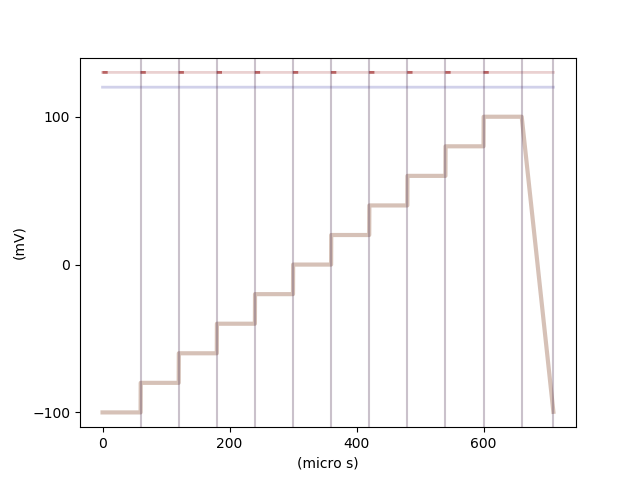

In [476]:
plotter(baseshape)

In [477]:
# Transform into sequence with repeating option
first_elem = broadbean.Element()
first_elem.addBluePrint(1, first_shape)

baseelem = broadbean.Element()
baseelem.addBluePrint(1, baseshape)

seq = broadbean.Sequence()
seq.setSR(SR)
seq.addElement(1, first_elem)
seq.setSequencingTriggerWait(1, 1)
seq.addElement(2, baseelem)

seq.setSequencingGoto(2, 1)
seq.setSequencingNumberOfRepetitions(2, pts_2-1)

seq.name = 'test'

<IPython.core.display.Javascript object>


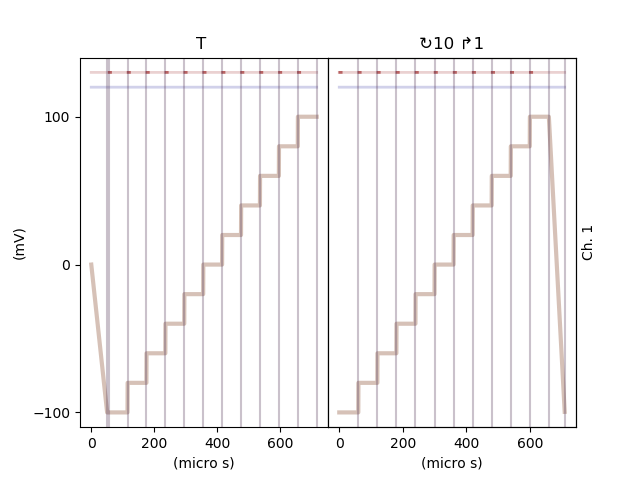

In [478]:
plotter(seq)

<IPython.core.display.Javascript object>


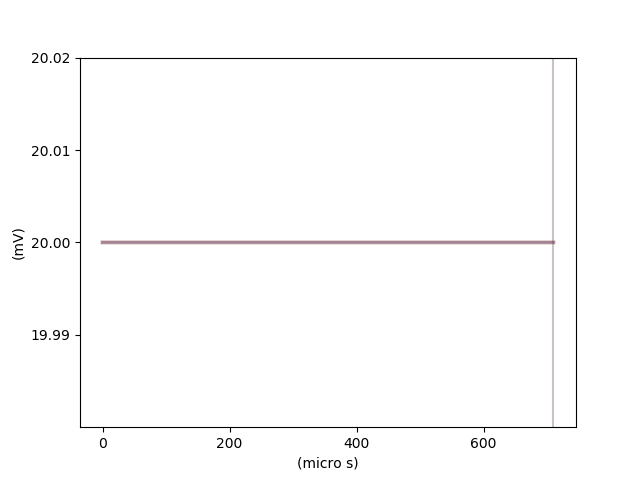

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=20.0, top=20.0
  'bottom=%s, top=%s') % (bottom, top))


In [479]:
# Channel 2 waveform
#t1 = 10e-6
t_elem = pts_1*t_step + t_r #60e-6*2

first_shape = broadbean.BluePrint()
first_shape.insertSegment(0, ramp_bb, (0,v2_pts[0]), dur=t_r)
first_shape.insertSegment(1, ramp_bb, (v2_pts[0],v2_pts[0]), dur=t_wait)
first_shape.insertSegment(2, ramp_bb, (v2_pts[0],v2_pts[0]), dur=t_elem-t_wait)
first_shape.setSR(SR)

baseshape_1 = broadbean.BluePrint()
baseshape_1.insertSegment(0, ramp_bb, (v2_pts[1],v2_pts[1]), dur = t_elem, name='volt')
baseshape_1.setSR(SR)

# baseshape_2 = broadbean.BluePrint()
# baseshape_2.insertSegment(0, ramp_bb, (0.4,0.4), dur=t_elem, name='volta')
# baseshape_2.insertSegment(1, ramp_bb, (0.4, 0), dur=t1)
# baseshape_2.setSR(SR)
#baseshape.setSegmentMarker('voltage', (2e-6, 4e-6), 1)
#baseshape.setSegmentMarker('volt', (2e-6, 4e-6), 1)
plotter(baseshape_1)

In [480]:
# Transform into sequence with repeating option
# first_elem_2 = broadbean.Element()
first_elem.addBluePrint(2, first_shape)
baseelem.addBluePrint(2, baseshape_1)

seq.addElement(1, first_elem_2)
seq.setSequencingTriggerWait(1, 1)
#seq.setSequencingNumberOfRepetitions(2, 6*2+1)
#seq.addElement(2, baseelem)

for i,v in enumerate(v2_pts[1:]):
    elem = baseelem.copy()
    elem.changeArg(2, 'volt', 'start', v)
    elem.changeArg(2, 'volt', 'stop', v)
    seq.addElement(i+1, elem)
#seq.setSequencingNumberOfRepetitions(3, 6*2+1)
seq.setSequencingGoto(i+1, 1)



<IPython.core.display.Javascript object>


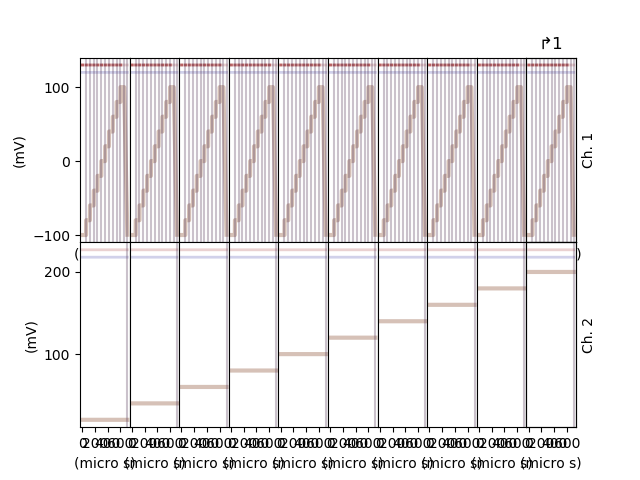

In [481]:
plotter(seq)

In [482]:
seq.setChannelAmplitude(1, awg.ch1.awg_amplitude())
seq.setChannelAmplitude(2, awg.ch2.awg_amplitude())
seqx_input = seq.outputForSEQXFile()
seqx_output = awg.makeSEQXFile(*seqx_input)

In [483]:
awg.clearSequenceList()
awg.clearWaveformList()
awg.sample_rate(SR)
awg.sendSEQXFile(seqx_output, 'test.seqx')
awg.loadSEQXFile('test.seqx')
awg.ch1.setSequenceTrack('test', 1)
awg.ch2.setSequenceTrack('test', 2)
awg.play()

In [484]:
hetsrc.frequency(410e6)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)
ro_att.attenuation(10)

acq_controller = raw_acq #post_iq_acq #raw_acq #or post...

acq_controller.pre_acquire_func = awg_trigger_func #trigger_awg_when_ready(awg) #awg_trigger_func
acq_controller.average_buffers(True)

samples = None #dummy number, if acquisition_time is specified that's what determines the number of samples
records = pts_1*pts_2 #*len(bias_voltages)
buffers = 1
acq_time = 10e-6
#acq_controller.demod_frq(20e6)
acq_controller.setup_acquisition(samples, records, buffers, acq_time = acq_time)


Setup capture: 0.9292799999999999 MB total
 * Buffers: 1 (0.9292799999999999 MB/buffer) | (Allocated buffers: 1 = 0.9292799999999999 MB)
 * Records: 121 (0.007679999999999999 MB/record)
 * Samples: 1920 (= 9.6 us)
 * Channels: 2


In [488]:
data = acq_controller.acquisition()

RuntimeError: ('error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [2396, c_void_p(1973551300608), 1000]', 'getting raw_acq_acquisition')

<IPython.core.display.Javascript object>


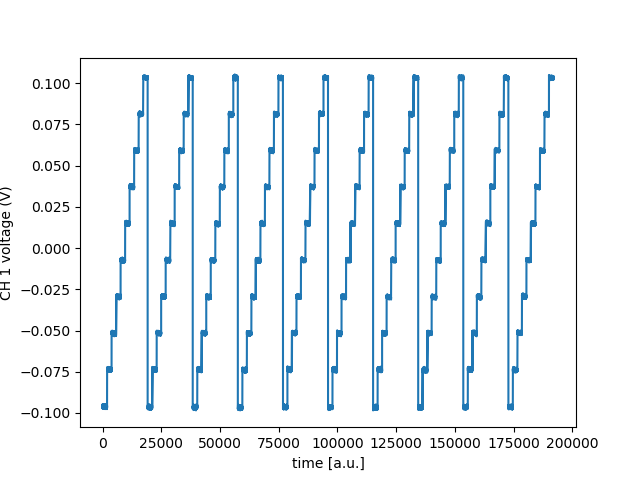

In [348]:
ch_1 = np.squeeze(data)[...,0].reshape(-1)
plt.figure()
plt.xlabel('time [a.u.]')
plt.ylabel('CH 1 voltage (V)')
plt.plot(ch_1)

<IPython.core.display.Javascript object>


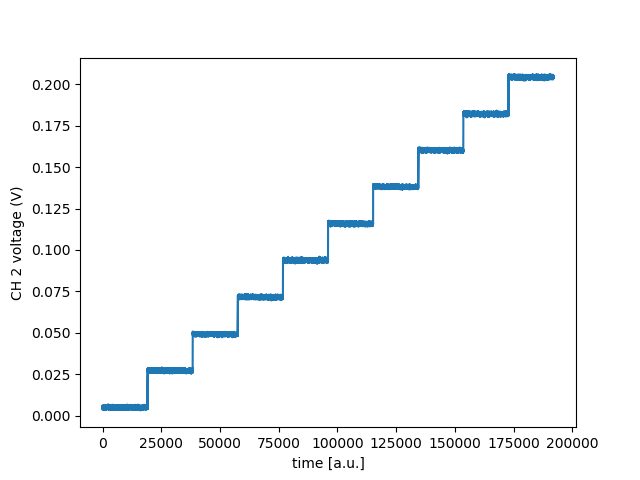

In [349]:
ch_2 = np.squeeze(data)[...,1].reshape(-1)

plt.figure()
plt.xlabel('time [a.u.]')
plt.ylabel('CH 2 voltage (V)')
plt.plot(ch_2)

<IPython.core.display.Javascript object>


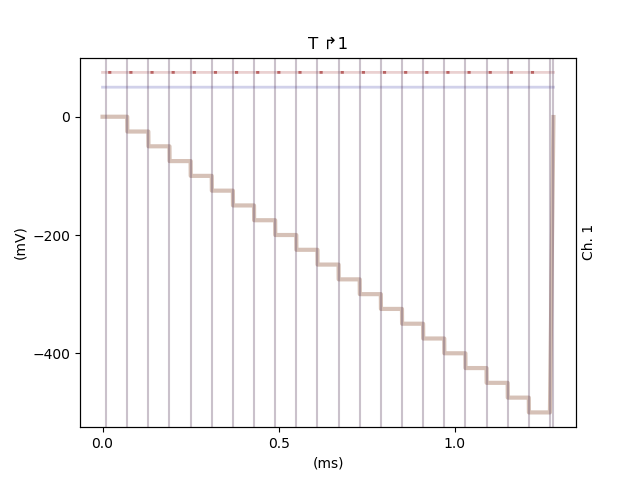

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


In [347]:
test_seq = AWGRamp1D(awg)

test_seq.chan_map = {
    1 : ['awg_voltage', 'ro_trigger'],
}
test_seq.chan_settings[1]['Vpp'] = 1.0
test_seq.chan_settings[1]['marker_hi'] = [1.5, 1.5, 1.5, 1.5]
test_seq.chan_settings[1]['marker_lo'] = [-0.3, -0.3, -0.3, -0.3]

test_seq.wait = 'first' #trigger wait to True before first element
test_seq.setup_awg(program_awg=True, start_awg=True, stop_awg=False,
                  initial_delay=10e-6, step_len=60e-6, voltage_points=21, start_voltage=0, stop_voltage=-0.5,
                  ramp_down_time=10e-6, SR=1e8, plot=True)

gate_voltages = test_seq.voltages


In [348]:
awg.force_triggerA()

In [169]:

hetsrc.frequency(410e6)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)
ro_att.attenuation(10)

post_iq_acq.pre_acquire_func = awg_trigger_func #trigger_awg_when_ready(awg) #awg_trigger_func
post_iq_acq.average_buffers(True)

samples = None #dummy number, if acquisition_time is specified that's what determines the number of samples
records = 101
buffers = 1
acq_time = 10e-6
post_iq_acq.demod_frq(20e6)
post_iq_acq.setup_acquisition(samples, records, buffers, acq_time = acq_time)



d:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:556: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


Setup capture: 1.5513599999999999 MB total
 * Buffers: 1 (1.5513599999999999 MB/buffer) | (Allocated buffers: 1 = 1.5513599999999999 MB)
 * Records: 101 (0.015359999999999999 MB/record)
 * Samples: 1920 (= 9.6 us)
 * Channels: 2


In [170]:
@setter(("time_sweep", "a.u."))
def time_sweep(a): 
    time.sleep(1e-3)


In [171]:
#%%timeit

@hardsweep(ind=[('gate_voltages', 'V', 'array')], dep=[('ch1_mag', 'V', 'array'),('ch2_mag', 'V', 'array'),
                                                      ('ch1_phase','deg','array'),('ch2_phase','deg','array')])
def alazar_meas(gate_voltages):
    
    data = post_iq_acq.acquisition()
    return gate_voltages, [np.abs(data[0,0,:,0]), np.abs(data[0,0,:,1]), np.angle(data[0,0,:,0]), np.angle(data[0,0,:,1])]

so = sweep(time_sweep, range(20))(alazar_meas(gate_voltages))

result = do_experiment('Test/None', so, live_plot=True)

Starting experimental run with id: 78


In [129]:
alazar.clear_buffers()

In [142]:
data = post_iq_acq.acquisition()

triggered


RuntimeError: ('error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [2396, c_void_p(2173546266624), 10000]', 'getting post_iq_acq_acquisition')

In [149]:
awg.force_triggerA()

## Old crap

In [ ]:
class old_AWGRamp2D(BroadBeanSequence):
    
    name = 'voltage_ramp'
    trigger_delay = 6e-6
    alazar_trigger_len = 6e-6
    voltages_1 = []
    voltages_2 = []
        
    def sequence(self, initial_delay_1, start_voltage_1, stop_voltage_1, voltage_points_1, step_len_1, ramp_down_time_1,
                 initial_delay_2, start_voltage_2, stop_voltage_2, voltage_points_2, step_len_2, ramp_down_time_2, SR):
        
        self.voltages_1 = np.linspace(start_voltage_1, stop_voltage_1, voltage_points_1)
        self.voltages_2 = np.linspace(start_voltage_2, stop_voltage_2, voltage_points_2)
        
        elements = []
        bps = BluePrints(self.chan_map, sample_rate=SR)
        
        cut_t = 0
        bps['ro_trigger_b'] = []
        bps['ro_trigger_g'] = []
        
        #first (fast) ramp       
        bps['fast'].insertSegment(0, ramp_bb, (start_voltage_1, start_voltage_1), 
                                             dur=initial_delay_1, name='voltage')    
        for i2,v2 in enumerate(self.voltages_2):
            for i, v in enumerate(self.voltages_1):
                bps['fast'].insertSegment(i+1+(i2+1)*voltage_points_1, ramp_bb, (v, v), 
                                                 dur=step_len_1, name='voltage')
                bps['ro_trigger_g'].append((initial_delay_1 + step_len_1*i+ step_len_2*i2 + self.trigger_delay, 
                                          self.alazar_trigger_len))
                
            bps['fast'].insertSegment(i+1+(i2+1)*voltage_points_1, ramp_bb, (stop_voltage_1, start_voltage_1), 
                                             dur=ramp_down_time_1, name='voltage')        


        # second (slow ramp)
        bps['slow'].insertSegment(0, ramp_bb, (start_voltage_2, start_voltage_2), 
                                         dur=initial_delay_2, name='voltage') 
        
        for i, v in enumerate(self.voltages_2):
            bps['slow'].insertSegment(i+1, ramp_bb, (v, v), 
                                             dur=step_len_2, name='voltage')
            #bps['ro_trigger_b'].append((initial_delay_2 + step_len_1 * i + self.trigger_delay, 
                                      #self.alazar_trigger_len))
            
        bps['slow'].insertSegment(-1, ramp_bb, (v, start_voltage_2), 
                                         dur=ramp_down_time_2, name='voltage')        

        
        
        elements.append(bb.blueprints2element(bps))
        
        
        return bb.elements2sequence(elements, self.name)
        
        

In [1081]:
@hardsweep(ind=[('bias_voltages', 'V', 'array'),('gate_voltages', 'V', 'array')], 
           dep=[('ch1_mag', 'V', 'array'),('ch2_mag', 'V', 'array'),
                ('ch1_phase','deg','array'),('ch2_phase','deg','array')])
def alazar_meas(gate_voltages, bias_voltages):
    fast_meshgrid, slow_meshgrid = np.meshgrid(bias_voltages, gate_voltages)
    fast_vector = fast_meshgrid.ravel()
    slow_vector = slow_meshgrid.ravel()
    
    data = acq_controller.acquisition()
    
    return [fast_vector, slow_vector], \
           [np.abs(data[0,0,:,0]), np.abs(data[0,1,:,0]), np.angle(data[0,0,:,0]), np.angle(data[0,1,:,0])]

so = alazar_meas(gate_voltages, bias_voltages)

result = do_experiment('Test/None', so, live_plot=True)

Starting experimental run with id: 182


KeyboardInterrupt: 